In [1]:
#learning resource: https://d2l.ai/chapter_recommender-systems

In [1]:
#getting movielens data
#!pip install sklearn
import os
import pandas as pd
import numpy

from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l
from mxnet.gluon import nn

import mxnet as mx

#scaling
from sklearn.preprocessing import StandardScaler

In [2]:
from datetime import datetime

In [3]:
npx.set_np()

In [4]:
#load data
os.chdir('G:/My Drive/2021/Bias')
#save matrice
#np.savetxt('test_matrice_reverse.csv', test_matrice_reverse, delimiter=",")
#np.savetxt('Zero_index.csv', Zero_index, delimiter=",")

#read the test matrice and data
test_matrice_reverse = pd.read_csv('test_matrice_reverse.csv', header=None).to_numpy()
Zero_index = pd.read_csv('Zero_index.csv', header=None).to_numpy()

In [5]:
#calculate sparsity
def get_sparsity(test_matrice):
    n_user, n_item = test_matrice.shape
    sparsity = 1 - (np.count_nonzero(test_matrice))/(n_user*n_item)
    print('data sparsity=', sparsity)
    
def get_data(user_t_data_path, test_matrice):
    #with open('user_tsinfo.txt') as f:
    with open(user_t_data_path) as f:
        infos = f.readlines()
    
    n_user, n_item = test_matrice[:, 1:].shape
    user_ids = infos[1].split(',')
    item_ids = infos[0].split(',')
    user_ids = user_ids[:-1]
    item_ids = item_ids[:-1]

    test_dt_obs = test_matrice[:,1:].flatten('F')
    test_dt_users = numpy.tile(user_ids, n_item)
    test_dt_items = numpy.repeat(item_ids, n_user)

    test_dt = pd.DataFrame(test_dt_users, columns=['userID'])
    test_dt['item'] = test_dt_items
    test_dt['obs'] = test_dt_obs
    
    return(test_dt, user_ids, item_ids)

test_sparse = get_sparsity(test_matrice_reverse[:, 1:])

test_dt, user_ids, item_ids = get_data('user_tsinfo.txt', test_matrice_reverse)
test_dt_non_zero = test_dt[test_dt['obs'] > 0]

#create dict to store item index
a = 1
item_index = {}
for st_ids in item_ids:
    item_index[st_ids] = a
    a += 1
    
a = 1 
user_index = {}
for ids in user_ids:
    user_index[int(ids)] = a
    a += 1

In [7]:
latlon_shape = pd.read_csv('G:/My Drive/2020/Bias/data-processing/latlon_shape.csv')
obs_Seattle = pd.read_csv('G:/My Drive/2020/Bias/data-processing/obs_Seattle.csv')

Seattle_geos = numpy.unique(list(obs_Seattle['GEOID10'].values))

latlon_shape = latlon_shape[['newid', 'geoid', 'obs', 'timestamp', 'accuracy']]
latlon_shape = latlon_shape[latlon_shape['geoid'].isin(Seattle_geos)]

get_hr = lambda x: datetime.fromtimestamp(x).hour
get_min = lambda x: int(datetime.fromtimestamp(x).minute/5)*5

latlon_shape['hr_str'] = list(map(str, list(latlon_shape['timestamp'].apply(get_hr).values)))
latlon_shape['minute_str'] = list(map(str, list(latlon_shape['timestamp'].apply(get_min).values)))
latlon_shape['geoids_str'] = list(map(str, list(latlon_shape['geoid'].values)))

latlon_shape['spatial_temp_id'] = latlon_shape['geoids_str'] + '_' + latlon_shape['hr_str'] + '_' + latlon_shape['minute_str']

latlon_shape = latlon_shape[['newid','spatial_temp_id','obs','timestamp']]

convert_st2index = lambda x: item_index[x]
latlon_shape['spatial_temp_id'] = latlon_shape['spatial_temp_id'].apply(convert_st2index)
convert_newid2index = lambda x: user_index[x]
latlon_shape['newid'] = latlon_shape['newid'].apply(convert_newid2index)

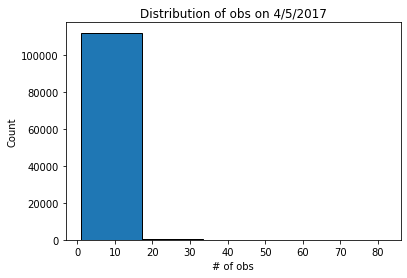

In [8]:
d2l.plt.hist(test_dt_non_zero['obs'], bins=5, ec='black')
d2l.plt.xlabel('# of obs')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of obs on 4/5/2017')
d2l.plt.show()

In [9]:
#Model implementation (https://d2l.ai/chapter_recommender-systems/mf.html)
#
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()
    
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

def train_recsys_rating(net, train_iter, test_iter, 
                        loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')
    
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    user_ids = numpy.unique(data.iloc[:, 0].values)
    
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in user_ids:
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

def split_data(data, num_users, num_items,
               split_mode='seq-aware', feedback='explicit', 
               test_ratio=0.1, batch_size=256):
    #data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = d2l.load_data_ml100k(train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = d2l.load_data_ml100k(test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(train_set, shuffle=True, last_batch='rollover',batch_size=batch_size)
    test_iter = gluon.data.DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

def model_fit(data, num_users, num_items, t_ratio, b_size, num_factos, train_itr, test_itr, num_epoch):
    devices = d2l.try_all_gpus()
    num_ids, num_sts, train_itr, test_itr = split_data(data,
                                                       num_users, 
                                                       num_items, 
                                                       split_mode='seq-aware', 
                                                       feedback='explicit', 
                                                       test_ratio=t_ratio, 
                                                       batch_size=b_size)

    net = MF(num_factos, num_users, num_items)
    net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
    lr, num_epochs, wd, optimizer = 0.002, num_epoch, 1e-5, 'adam'
    loss = gluon.loss.L2Loss()
    trainer = gluon.Trainer(net.collect_params(), optimizer,
                            {"learning_rate": lr, 'wd': wd})
    train_recsys_rating(net, train_itr, test_itr, loss, trainer, num_epochs,
                        devices, evaluator)
    

    
    

In [10]:
#num_ids = len(numpy.unique(latlon_shape['newid']))
#num_sts = len(numpy.unique(latlon_shape['spatial_temp_id']))
num_ids, num_sts = test_matrice_reverse[:,1:].shape

In [11]:
num_ids, num_sts, train_itr, test_itr = split_data(latlon_shape, num_ids, num_sts)

train loss 0.425, test RMSE 6.999
69417.1 examples/sec on [cpu(0)]


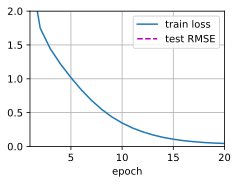

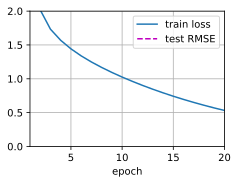

In [12]:
#256 seems to be a good batch size in this case
model_fit(latlon_shape, num_ids, num_sts, 0.1, 256, 100, train_itr, test_itr, 20)
#model_fit(latlon_shape, num_ids, num_sts, 0.1, 512, 100,  train_itr, test_itr)
#train loss 0.018, test RMSE 7.103
#146640.1 examples/sec on [cpu(0)]
#model_fit(latlon_shape, num_ids, num_sts, 0.1, 128, 100,  train_itr, test_itr)
#train loss 0.165, test RMSE 6.896
#32524.5 examples/sec on [cpu(0)]


#batch size = 256 should be the good size in this case
model_fit(latlon_shape, num_ids, num_sts, 0.1, 256, 18, train_itr, test_itr, 20)
#train loss 0.421, test RMSE 6.993
#85300.4 examples/sec on [cpu(0)]

#model_fit(latlon_shape, num_ids, num_sts, 0.1, 512, 18,  train_itr, test_itr)
#train loss 0.123, test RMSE 7.081
#143131.8 examples/sec on [cpu(0)]
#model_fit(latlon_shape, num_ids, num_sts, 0.1, 128, 18,  train_itr, test_itr)
#train loss >1

In [13]:
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn

npx.set_np()

In [14]:
#Autoreoder
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # Mask the gradient during training
            return pred * np.sign(input)
        else:
            return pred
        
def evaluator(network, inter_matrix, test_data, devices):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, devices, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

In [15]:
def split_data(data, num_users, num_items,
               split_mode='seq-aware', feedback='explicit', 
               test_ratio=0.1, batch_size=256):
    #data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, train_inter_mat = d2l.load_data_ml100k(train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, test_inter_mat = d2l.load_data_ml100k(test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(train_set, shuffle=True, last_batch='rollover',batch_size=batch_size)
    test_iter = gluon.data.DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter, test_inter_mat


def auto_encoder(data, num_users, num_items, 
                 num_hidden, num_epoch, train_iter, 
                 test_iter, test_inter_mat):
    devices = d2l.try_all_gpus()
    
    net = AutoRec(num_hidden, num_users)
    net.initialize(ctx=devices, force_reinit=True, 
                   init=mx.init.Normal(0.01))
    lr, num_epochs, wd, optimizer = 0.002, num_epoch, 1e-5, 'adam'
    loss = gluon.loss.L2Loss()
    trainer = gluon.Trainer(net.collect_params(), optimizer,
                            {"learning_rate": lr, 'wd': wd})
    d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer,
                            num_epochs, devices, evaluator, 
                            inter_mat=test_inter_mat)
    

NameError: name 'train_iter' is not defined

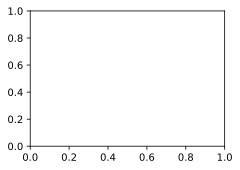

In [19]:
num_epochs = 20
timer = d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], 
                        ylim=[0, 2],
                        legend=['train loss', 'test RMSE'])
for epoch in range(num_epochs):
    metric, l = d2l.Accumulator(3), 0.
    for i, values in enumerate(train_iter):
        timer.start()
        input_data = []
        values = values if isinstance(values, list) else [values]
        for v in values:
            input_data.append(gluon.utils.split_and_load(v, devices))
            print(len(input_data))
        train_feat = input_data[0:-1] if len(values) > 1 else input_data
        train_label = input_data[-1]
        print(train_feat)
        print(train_label)
        with autograd.record():
            preds = [net(*t) for t in zip(*train_feat)]
            ls = [loss(p, s) for p, s in zip(preds, train_label)]
        [l.backward() for l in ls]
        l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
        trainer.step(values[0].shape[0])
        metric.add(l, values[0].shape[0], values[0].size)
        timer.stop()
    if len(kwargs) > 0:  # It will be used in section AutoRec
        test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                              devices)
    else:
        test_rmse = evaluator(net, test_iter, devices)
    train_l = l / (i + 1)
    animator.add(epoch + 1, (train_l, test_rmse))
print(f'train loss {metric[0] / metric[1]:.3f}, '
      f'test RMSE {test_rmse:.3f}')
print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
      f'on {str(devices)}')

In [20]:
num_users, num_items, train_itr, test_itr, test_intr_mat = split_data(latlon_shape, 
                                                             num_ids, 
                                                             num_sts,
                                                             split_mode='seq-aware', 
                                                             feedback='explicit', 
                                                             test_ratio=0.1, 
                                                             batch_size=256)
    

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


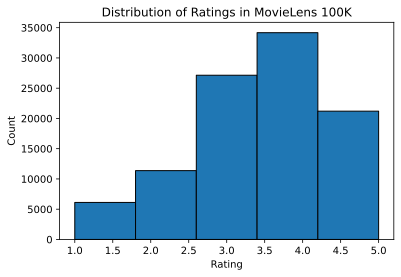

TypeError: evaluator() missing 1 required positional argument: 'devices'

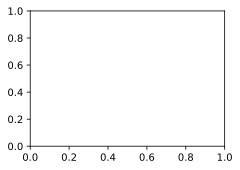

In [21]:
#Sequential recsys
#@save
#example in mxnet
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(test_ratio=0.1, 
                                                                        batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

scores = net(np.array([20], dtype='int', ctx=devices[0]),
             np.array([30], dtype='int', ctx=devices[0]))
scores

In [ ]:
devices = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(np.array(train_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=d2l.get_dataloader_workers())
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices, evaluator, inter_mat=test_inter_mat)

In [ ]:
devices = d2l.try_all_gpus()

net = AutoRec(num_hidden, num_ids)
net.initialize(ctx=devices, force_reinit=True, 
               init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()

trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

d2l.train_recsys_rating(net, train_itr, test_itr, loss, trainer,
                        num_epochs, devices, evaluator, 
                        inter_mat=test_inter_mat)